# The code assumes you have an OHLC data of historical values imported in Python. This has been covered in previous articles

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import yahoo_fin.stock_info as si
import matplotlib.pyplot as plt


In [9]:
ticker = 'BTC-USD'
start_date = '2017-09-14'
end_date = '2023-05-29'

lookback_ma = 200
lookback_norm = 50

def load_data(ticker):
    try:            
      data = yf.download(ticker, start_date, end_date)
      data.reset_index(inplace=True)
      return data
    except Exception as e:
      print(f'An exception occurred while executing load_data: {e}')

In [10]:
# Defining the primal functions
def add_column(data, times):
    for i in range(1, times + 1):
        new = np.zeros((len(data), 1), dtype = float)
        data = np.append(data, new, axis = 1)
    return data

def delete_column(data, index, times):
    for i in range(1, times + 1):
        data = np.delete(data, index, axis = 1)
    return data

def delete_row(data, number):
    data = data[number: , ]
    return data

In [11]:
# Defining the moving average function
def ma(data, lookback, close, position): 
    data = add_column(data, 1)
    for i in range(len(data)):
        try:
            data[i, position] = (data[i - lookback + 1:i + 1, close].mean())
        except IndexError:
            pass
    data = delete_row(data, lookback)
    return data

In [12]:
# Defining the normalization function
def normalized_index(data, lookback, close, position):
    data = add_column(data, 1)
    for i in range(len(data)):
        try:
            data[i, position] = (data[i, close] - min(data[i - lookback + 1:i + 1, close])) / (max(data[i - lookback + 1 : i + 1, close]) - min(data[i - lookback + 1 : i + 1, close]))
        except ValueError:
            pass
    data[:, position] = data[:, position] * 100  
    data = delete_row(data, lookback)
    return data

In [13]:
def signal(data, close_column, ma_column, normalized_distance_column, buy_column, sell_column):
    data = add_column(data, 2)
    for i in range(len(data)):
       try:
           # Bullish signal
           if data[i, normalized_distance_column] > 100 and \
              data[i - 15, normalized_distance_column] == 100 and \
              data[i, close_column] < data[i - 15, close_column] and \
              data[i, close_column] < data[i, ma_column]:    
              data[i + 1, buy_column] = 1
              print(f"Bullish signal : {i + 1, buy_column}")
           # Bearish signal
           elif data[i, normalized_distance_column] > 100 and \
              data[i - 15, normalized_distance_column] == 100 and \
              data[i, close_column] > data[i - 15, close_column] and \
              data[i, close_column] > data[i, ma_column]:
              data[i + 1, sell_column] = -1
              print(f"Bearish signal : {i + 1, sell_column}")
       except IndexError:
            pass
    return data

[*********************100%***********************]  1 of 1 completed


/var/folders/69/k2882s3d5jbbkmnl3p42wg4ws68910/T/ipykernel_13335/1309851059.py:6: RuntimeWarning: Mean of empty slice.
  data[i, position] = (data[i - lookback + 1:i + 1, close].mean())
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


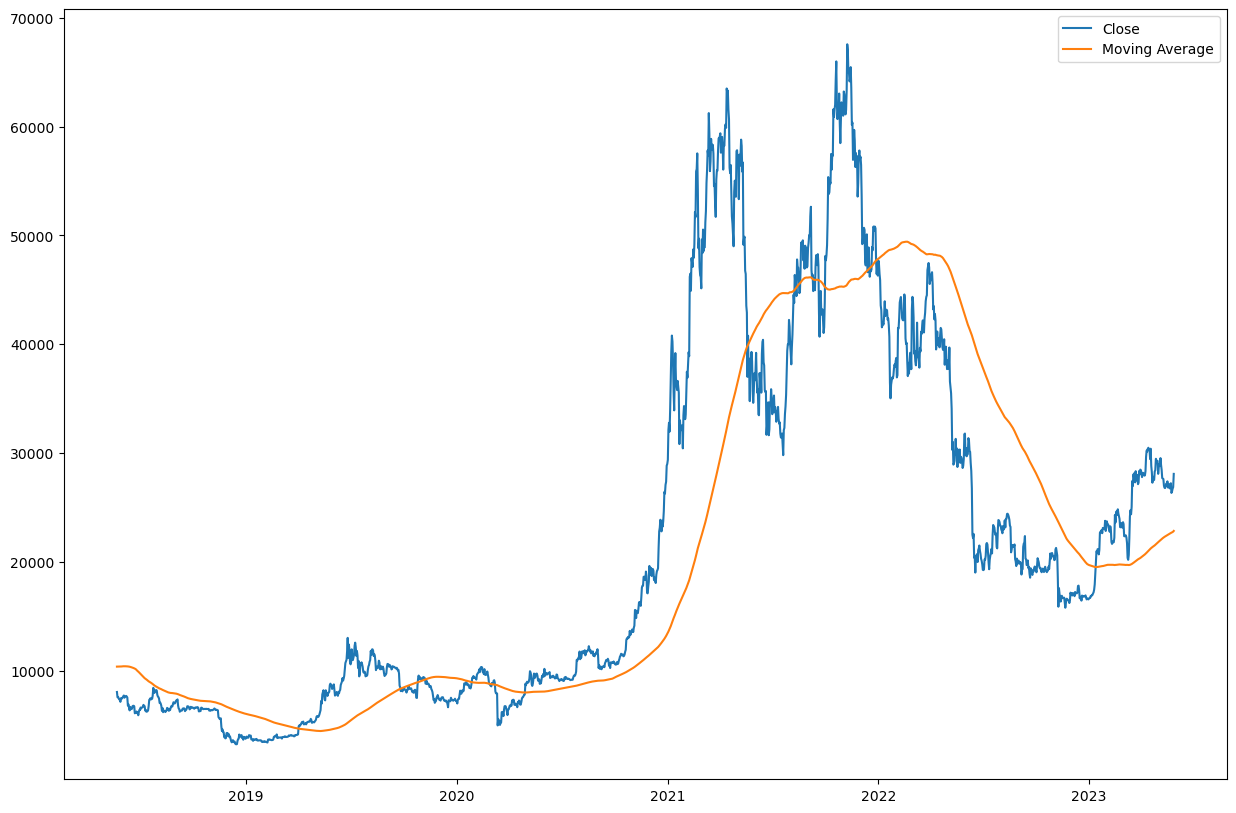

In [14]:
my_data = load_data(ticker)

# Calling a 200-period moving average applied on the close price
my_data = ma(my_data, lookback_ma, 4, 7)

# Adding one extra column for differencing
my_data = add_column(my_data, 1)

# Calculating the absolute distance between the close and the moving average
my_data[:, 8] = abs(my_data[:, 4] - my_data[:, 7])

# Normalizing the distance between 0 and 100 with a period of 50
my_data = normalized_index(my_data, lookback_norm, 4, 9)

# Normalizing the distance between 0 and 100 with a period of 50
my_data = signal(my_data, 4, 7, 9, 10, 11)

# Plotting the closing price, moving average, and signals
plt.figure(figsize=(15,10))
plt.plot(my_data[:, 0], my_data[:, 4], label='Close')
plt.plot(my_data[:, 0], my_data[:, 7], label='Moving Average')
# plt.scatter(my_data[:, 0], my_data[:, 4][my_data[:, 10] == 1], color='green', label='Buy Signal')
# plt.scatter(my_data[:, 0], my_data[:, 4][my_data[:, 11] == -1], color='red', label='Sell Signal')
plt.legend()
plt.show()


